**Cloning Github Repository**

In [1]:
!git clone https://github.com/call-me-jot/surface-crack-detector.git
%cd /content/surface-crack-detector
!git pull origin master
!git branch
!git checkout -b feature-cnn-training


Cloning into 'surface-crack-detector'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 11), reused 23 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 1.84 MiB | 3.69 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/surface-crack-detector
From https://github.com/call-me-jot/surface-crack-detector
 * branch            master     -> FETCH_HEAD
Already up to date.
* master
Switched to a new branch 'feature-cnn-training'
* feature-cnn-training
  master
On branch feature-cnn-training
nothing to commit, working tree clean


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()

Saving dataset[1].zip to dataset[1].zip


In [ ]:
zip_path = "/content/surface-crack-detector/dataset[1].zip"  # Change this to the actual filename

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")  # Extract to a directory


In [ ]:
# Define dataset paths
dataset_path = "/content/dataset"
positive_dir = os.path.join(dataset_path, "Positive")  # Crack images
negative_dir = os.path.join(dataset_path, "Negative")  # No-crack images

# Get all image paths
crack_images = glob(os.path.join(positive_dir, "*.jpg"))
no_crack_images = glob(os.path.join(negative_dir, "*.jpg"))

# Print dataset info
print(f"Total Crack Images: {len(crack_images)}")
print(f"Total No-Crack Images: {len(no_crack_images)}")


Total Crack Images: 20000
Total No-Crack Images: 20000


<ipython-input-6-7a83c103eb35>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="coolwarm")


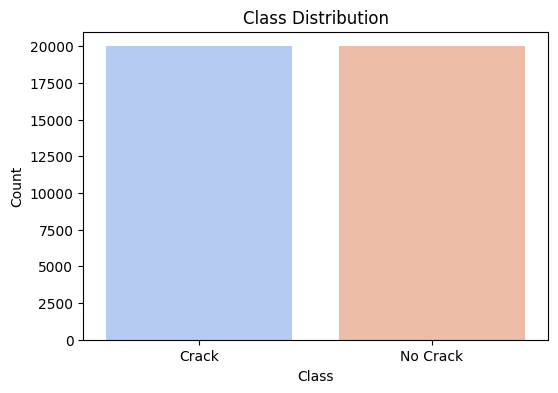

In [ ]:
labels = ['Crack'] * len(crack_images) + ['No Crack'] * len(no_crack_images)

plt.figure(figsize=(6, 4))
sns.countplot(x=labels, palette="coolwarm")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**Checking Image Sizes**

Average Image Width: 227.00, Height: 227.00


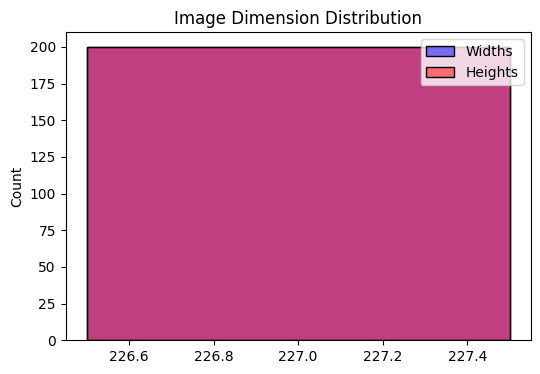

In [ ]:
image_sizes = []
for img_path in crack_images[:100] + no_crack_images[:100]:  # Checking 100 images per class
    img = Image.open(img_path)
    image_sizes.append(img.size)

widths, heights = zip(*image_sizes)
print(f"Average Image Width: {np.mean(widths):.2f}, Height: {np.mean(heights):.2f}")

plt.figure(figsize=(6, 4))
sns.histplot(widths, kde=True, color="blue", label="Widths")
sns.histplot(heights, kde=True, color="red", label="Heights")
plt.legend()
plt.title("Image Dimension Distribution")
plt.show()


**Compute Image Stats(Mean & Std)**

In [ ]:
def calculate_stats(image_list):
    means, stds = [], []

    for img_path in image_list[:500]:  # Checking first 500 images
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize
        means.append(np.mean(img))
        stds.append(np.std(img))

    return np.mean(means), np.mean(stds)

crack_mean, crack_std = calculate_stats(crack_images)
no_crack_mean, no_crack_std = calculate_stats(no_crack_images)

print(f"Crack Images - Mean: {crack_mean:.3f}, Std: {crack_std:.3f}")
print(f"No Crack Images - Mean: {no_crack_mean:.3f}, Std: {no_crack_std:.3f}")


Crack Images - Mean: 0.642, Std: 0.121
No Crack Images - Mean: 0.719, Std: 0.034


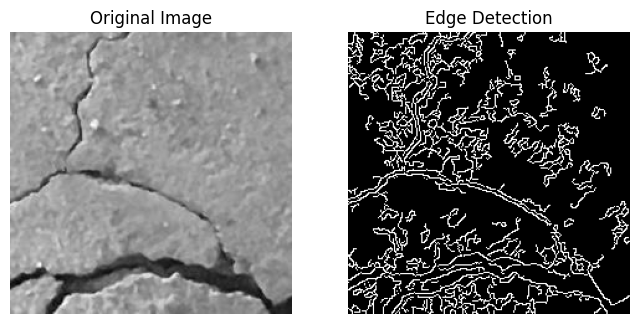

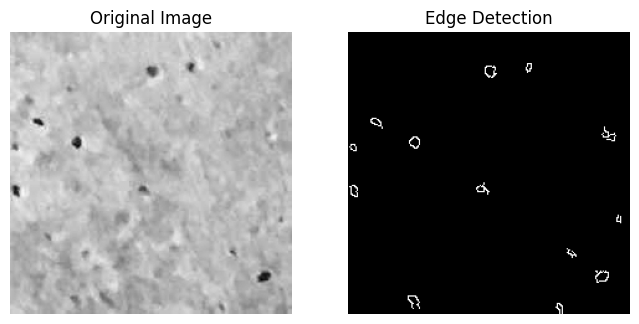

In [ ]:
def show_edges(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, threshold1=50, threshold2=150)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Edge Detection")
    plt.axis("off")

    plt.show()

# Test edge detection
show_edges(crack_images[0])
show_edges(no_crack_images[0])


📌 Preprocessing Steps

1️⃣ Load images & resize (Ensure all images have the same shape)

2️⃣ Convert to grayscale (optional)

3️⃣ Normalize pixel values (Scale values between 0-1 or -1 to 1)

4️⃣ Data Augmentation (Flip, rotate, zoom, etc.)

5️⃣ Prepare for model training (Create train-test splits & format data)



In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values (0 to 1)
    validation_split=0.2  # 80-20 train-validation split
)

# Load training data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'  # Load training set
)

# Load validation data
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'  # Load validation set
)

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [ ]:
# Define data augmentation pipeline
augment_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Apply augmentation to training set
train_augmented = augment_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)


Found 32000 images belonging to 2 classes.


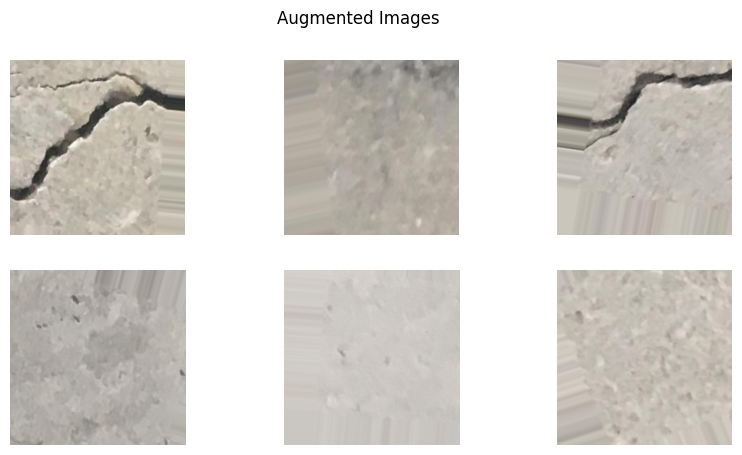

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images
augmented_images, _ = next(train_augmented)

# Plot some images
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
plt.suptitle("Augmented Images")
plt.show()


**Simple CNN**

In [ ]:
from tensorflow.keras import layers, models

# Define CNN architecture
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**Training**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint callback to save weights
checkpoint_path = "cnn_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
epochs = 20

history = model.fit(
    train_augmented,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[checkpoint_callback]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8373 - loss: 0.3537
Epoch 1: val_accuracy improved from -inf to 0.98150, saving model to cnn_checkpoint.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 384s 376ms/step - accuracy: 0.8374 - loss: 0.3536 - val_accuracy: 0.9815 - val_loss: 0.0513
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9748 - loss: 0.0792
Epoch 2: val_accuracy improved from 0.98150 to 0.98850, saving model to cnn_checkpoint.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 386s 386ms/step - accuracy: 0.9748 - loss: 0.0792 - val_accuracy: 0.9885 - val_loss: 0.0701
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9691 - loss: 0.1030
Epoch 3: val_accuracy improved from 0.98850 to 0.99175, saving model to cnn_checkpoint.weights.h5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 430s 374ms/step - accuracy: 0.9691 - loss: 0.1030 - val_accuracy: 0.9918 - val_loss: 0.0323
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.

**Saving the model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/My Drive/Augmented_data_cnn_trained_model.h5")
model.save("Augmented_data_cnn_trained_model.h5")
print("Model saved successfully!")

Model saved successfully!


**Accuracy value**

In [ ]:
print("Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])


Accuracy: 0.9908750057220459
Validation Accuracy: 0.9978749752044678


**Plotting Model Accuracy and Loss**

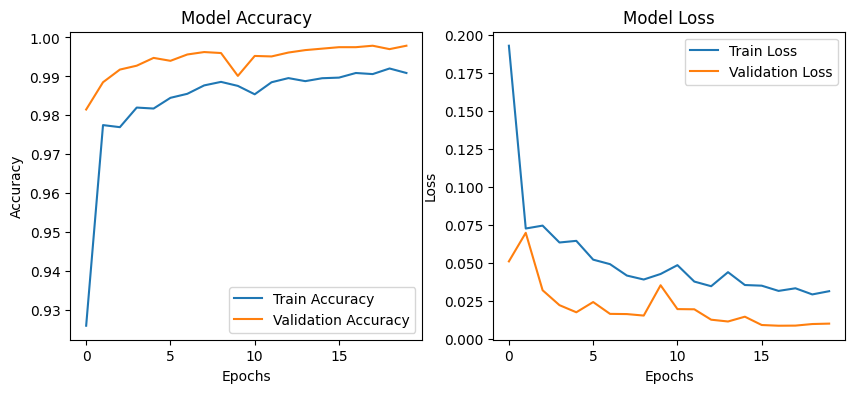

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy & loss
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")

plt.show()


In [2]:
!git config --global user.email "kamini4@uwo.ca"
!git config --global user.name "Keivan-Amini96"

In [3]:
!git status

On branch feature-cnn-training
nothing to commit, working tree clean


In [ ]:
!git fetch origin
!git pull origin feature-cnn-training --rebase


From https://github.com/call-me-jot/surface-crack-detector
 * branch            feature-cnn-training -> FETCH_HEAD
hint: use --reapply-cherry-picks to include skipped commits
hint: Disable this message with "git config advice.skippedCherryPicks false"
Successfully rebased and updated refs/heads/feature-cnn-training.


In [ ]:
!git push origin master

Everything up-to-date
